<a href="https://colab.research.google.com/github/Reyad02/PoultryScan/blob/main/MobileNetV3_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# prompt: connect with dirve

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image
# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [ ]:
#Load Training Data
train_data_dir = '/content/drive/MyDrive/DIP_Splited_Aug_Dataset/train'
filepaths = []
labels = []
folds = os.listdir(train_data_dir)

for fold in folds:
    foldpath = os.path.join(train_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)

        filepaths.append(fpath)
        labels.append(fold)

#Concatenate data paths
Fseries = pd.Series(filepaths, name = 'filepaths')
Lseries = pd.Series(labels, name = 'labels')

train_df = pd.concat([Fseries, Lseries], axis = 1)

In [ ]:
#Load Testing Data
train_data_dir = '/content/drive/MyDrive/DIP_Splited_Aug_Dataset/test'
filepaths = []
labels = []
folds = os.listdir(train_data_dir)

for fold in folds:
    foldpath = os.path.join(train_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)

        filepaths.append(fpath)
        labels.append(fold)

#Concatenate data paths
Fseries = pd.Series(filepaths, name = 'filepaths')
Lseries = pd.Series(labels, name ='labels')

ts_df = pd.concat([Fseries, Lseries], axis = 1)

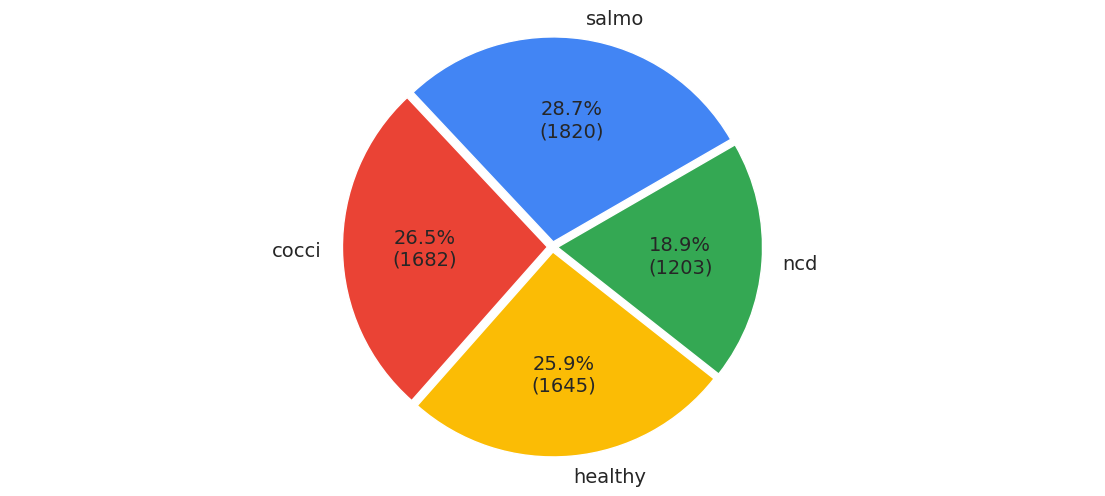

In [ ]:
#Graph Dataset Split
plt.figure(figsize = (14, 6))
plt.rcParams.update({'font.size': 14})
data_balance = train_df.labels.value_counts()

def custom_autopct(pct):
    total = sum(data_balance)
    val = int(round(pct * total / 100.0))
    return "{:.1f}%\n({:d})".format(pct, val)

plt.pie(data_balance,
        labels = data_balance.index,
        autopct = custom_autopct,
        colors = ['#4285f4', '#ea4335', '#fbbc05', '#34a853'],
        explode = (0.025, 0.025, 0.025, 0.025),
        startangle = 30);
plt.axis('equal')
plt.show()

In [ ]:
#Split dataset
valid_df, test_df = train_test_split(ts_df, train_size = 0.5, shuffle = True, random_state = 42)

In [ ]:
# Augment and Preprocess Scans
batch_size =64
img_size = (224, 224)

tr_gen = ImageDataGenerator()
test_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                       class_mode='categorical',
                                       color_mode='rgb', shuffle=True, batch_size=batch_size)

test_gen = test_gen.flow_from_dataframe(ts_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                        class_mode='categorical',
                                        color_mode='rgb', shuffle=False, batch_size=batch_size)
# batch_size = 64
# img_size = (224,224)

# tr_gen = ImageDataGenerator()
# ts_gen = ImageDataGenerator()

# train_gen = tr_gen.flow_from_dataframe(train_df, x_col = 'filepaths', y_col = 'labels', target_size = img_size, class_mode = 'categorical',
#                                     color_mode = 'rgb', shuffle = True, batch_size = batch_size)

# valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col = 'filepaths', y_col = 'labels', target_size = img_size, class_mode = 'categorical',
#                                     color_mode = 'rgb', shuffle = True, batch_size = batch_size)

# test_gen = ts_gen.flow_from_dataframe(test_df, x_col = 'filepaths', y_col = 'labels', target_size = img_size, class_mode = 'categorical',
#                                     color_mode = 'rgb', shuffle = False, batch_size = batch_size)

Found 6350 validated image filenames belonging to 4 classes.
Found 1590 validated image filenames belonging to 4 classes.


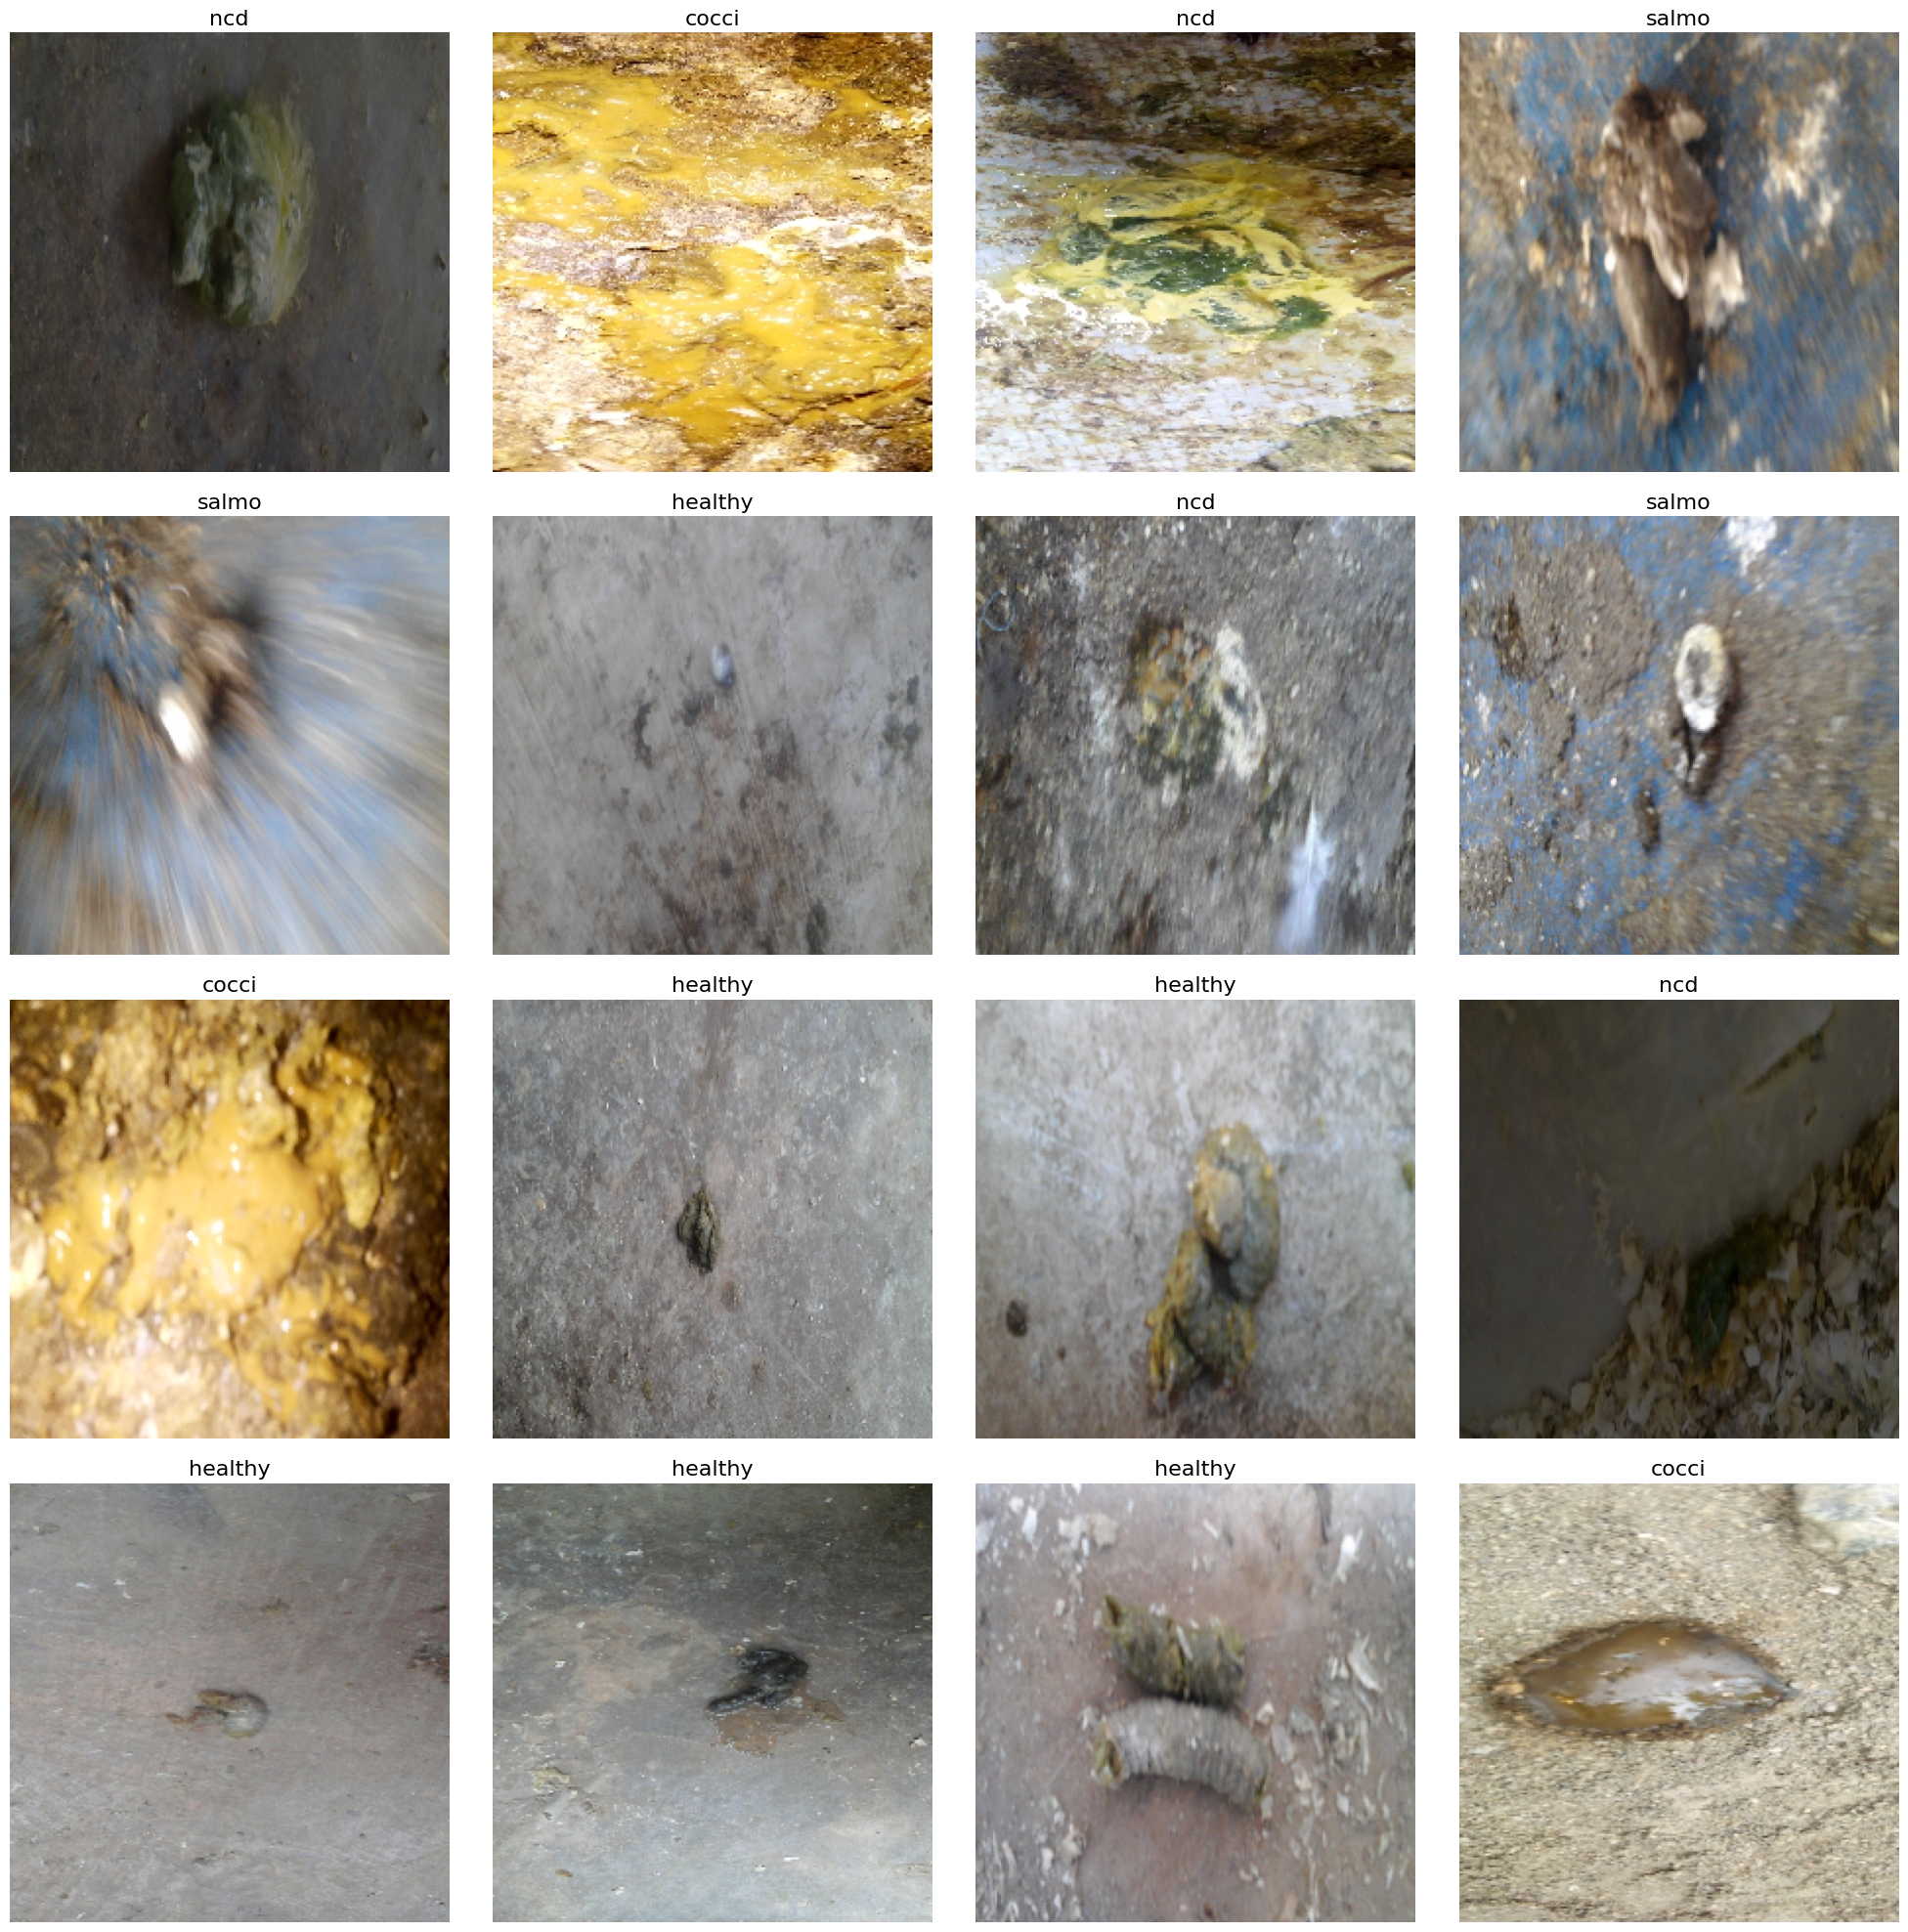

In [ ]:
#Plot Processed Scans
g_dict = train_gen.class_indices
classes = list(g_dict.keys())
images, labels = next(train_gen)

plt.figure(figsize = (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name, color = 'black', fontsize = 16)
    plt.axis('off')
plt.tight_layout()
plt.show()

([<matplotlib.patches.Wedge at 0x79036685d780>,
 [Text(-1.1187437299570697, 0.11847981550349934, 'Training'),
  Text(1.118743735503509, -0.11847976313132515, 'Testing')],
 [Text(-0.6215242944205942, 0.0658221197241663, '80.0%'),
  Text(0.6215242975019494, -0.06582209062851396, '20.0%')])

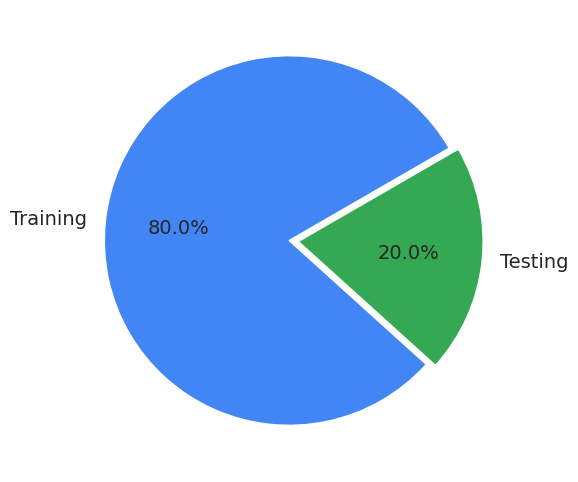

In [ ]:
# Graph Dataset Directories
plt.figure(figsize=(14, 6))
plt.rcParams.update({'font.size': 14})

plt.pie([len(train_df), len(ts_df)],
        labels=['Training', 'Testing'],
        colors=['#4285f4', '#34a853'],
        autopct='%.1f%%',
        explode=(0.025, 0.025),
        startangle=30)


In [ ]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))  # to define the number of classes in the dense layer

# create pre-trained model (you can use a pre-trained model such as MobileNetV3, VGG, ResNet)
# we will use MobileNetV3 in this case
base_model = tf.keras.applications.MobileNetV3Large(
    include_top=False, weights="imagenet", input_shape=img_shape, pooling='max'
)

model = Sequential([
    base_model,
    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
    Dense(256, kernel_regularizer=regularizers.l2(l=0.016), activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006), activation='relu'),
    Dropout(rate=0.45, seed=123),
    Dense(class_count, activation='softmax')
])

model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

12683000/12683000 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3large (Function  (None, 960)               2996352   
 al)                                                             
                                                                 
 batch_normalization (Batch  (None, 960)               3840      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               246016    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 1028      
                                                         

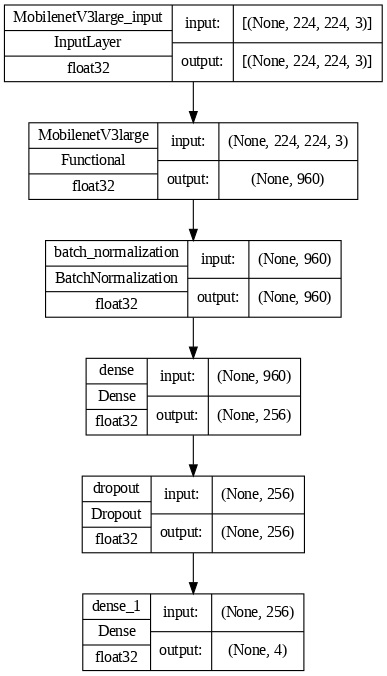

In [ ]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True,show_dtype=True,dpi=80)

In [ ]:
epochs = 10   # number of all epochs in training
history = model.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= test_gen,
                    validation_steps= None, shuffle= False)

Epoch 1/10
100/100 [==============================] - 5729s 57s/step - loss: 5.9735 - accuracy: 0.9195 - val_loss: 5.0698 - val_accuracy: 0.8660
Epoch 2/10
100/100 [==============================] - 338s 3s/step - loss: 3.4630 - accuracy: 0.9910 - val_loss: 3.2546 - val_accuracy: 0.8730
Epoch 3/10
100/100 [==============================] - 346s 3s/step - loss: 2.1419 - accuracy: 0.9943 - val_loss: 2.1678 - val_accuracy: 0.8623
Epoch 4/10
100/100 [==============================] - 353s 4s/step - loss: 1.3794 - accuracy: 0.9953 - val_loss: 1.4441 - val_accuracy: 0.8937
Epoch 5/10
100/100 [==============================] - 354s 4s/step - loss: 0.9022 - accuracy: 0.9984 - val_loss: 0.9853 - val_accuracy: 0.9075
Epoch 6/10
100/100 [==============================] - 358s 4s/step - loss: 0.6091 - accuracy: 0.9984 - val_loss: 0.7706 - val_accuracy: 0.9044
Epoch 7/10
100/100 [==============================] - 364s 4s/step - loss: 0.4262 - accuracy: 0.9989 - val_loss: 0.5457 - val_accuracy: 0.93

In [ ]:
import torch

In [ ]:
# Save the entire model
model.save('/content/drive/MyDrive/Models_for_Enesemble_Learning/mobileNetV3_model.h5')

In [ ]:
#Graph results
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i + 1 for i in range(len(tr_acc))]
loss_label = f'Best epoch = {str(index_loss + 1)}'
acc_label = f'Best epoch = {str(index_acc + 1)}'

plt.figure(figsize = (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, color = '#157AFF', label = 'Training loss')
plt.plot(Epochs, val_loss, color = '#FFBB33', label = 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s = 150, color = 'red', label = loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, color = '#157AFF', label = 'Training Accuracy')
plt.plot(Epochs, val_acc, color = '#FFBB33', label = 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s = 150, color = 'red', label = acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [ ]:
#Results for training, validating, testing

# Results for training and testing
train_score = model.evaluate(train_gen, verbose=1)
test_score = model.evaluate(test_gen, verbose=1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

25/25 [==============================] - 66s 3s/step - loss: 0.4495 - accuracy: 0.9063
Train Loss:  0.41169098019599915
Train Accuracy:  0.9149606227874756
--------------------
Test Loss:  0.4495376646518707
Test Accuracy:  0.906289279460907


In [ ]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

25/25 [==============================] - 59s 2s/step


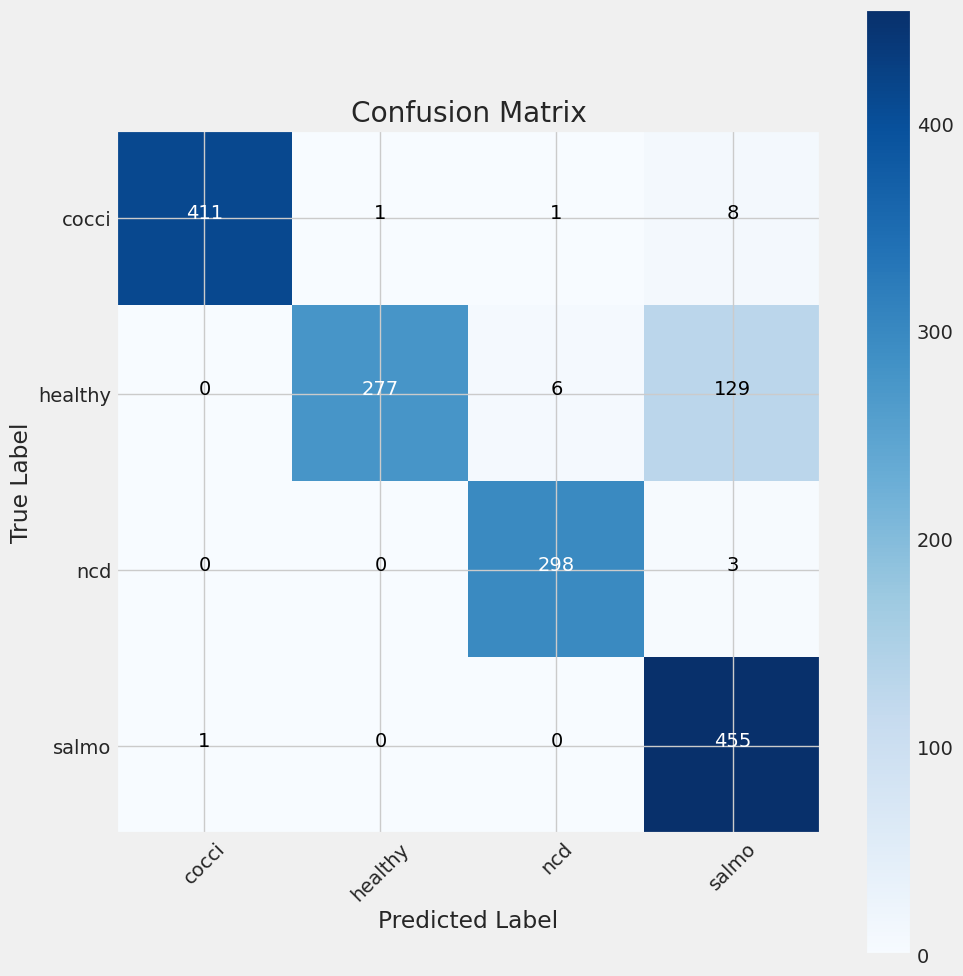

In [ ]:
#Confusion matrix
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize = (10, 10))
plt.imshow(cm, interpolation = 'nearest', cmap = plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation = 45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment = 'center', color = 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [ ]:
#F1-score
print(classification_report(test_gen.classes, y_pred, target_names = classes))

              precision    recall  f1-score   support

       cocci       1.00      0.98      0.99       421
     healthy       1.00      0.67      0.80       412
         ncd       0.98      0.99      0.98       301
       salmo       0.76      1.00      0.87       456

    accuracy                           0.91      1590
   macro avg       0.93      0.91      0.91      1590
weighted avg       0.93      0.91      0.90      1590



In [ ]:
from sklearn.metrics import roc_curve, auc
y_pred = model.predict(test_gen)

25/25 [==============================] - 62s 2s/step


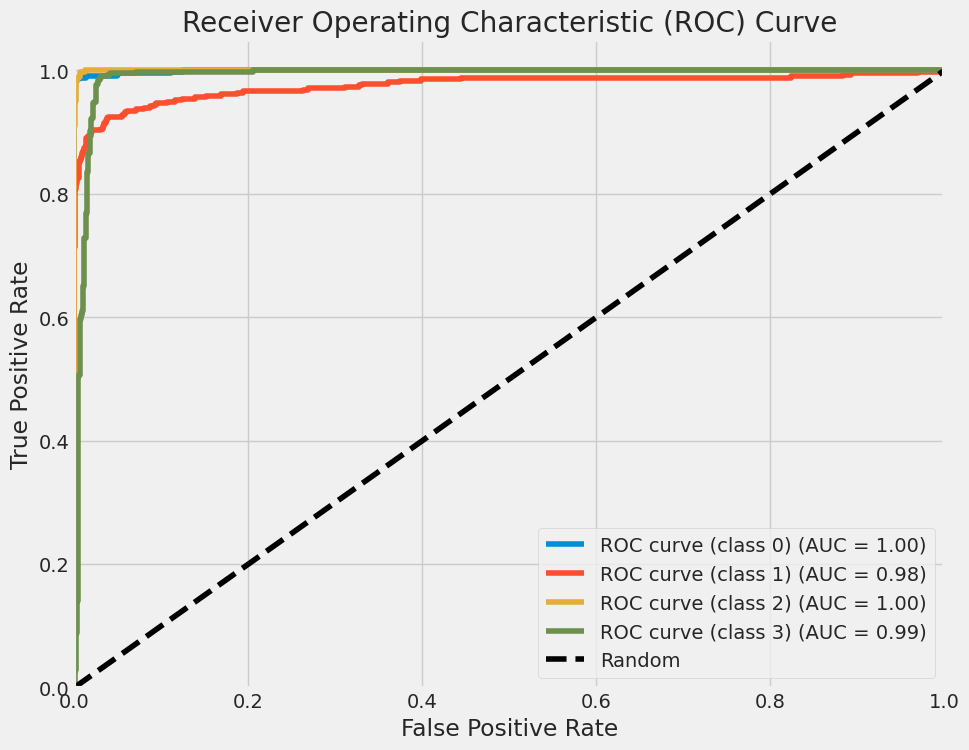

In [ ]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

# Check if test_gen.classes is a list of one-hot encoded vectors
if isinstance(test_gen.classes[0], list) or isinstance(test_gen.classes[0], np.ndarray):
    true_labels = np.argmax(test_gen.classes, axis=1)
else:
    true_labels = test_gen.classes

for i in range(class_count):  # class_count is the number of classes
    fpr[i], tpr[i], _ = roc_curve(np.array(true_labels) == i, y_pred[:, i])  # Treat i-th class as positive, rest as negative
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(10, 8))
for i in range(class_count):
    plt.plot(fpr[i], tpr[i], label='ROC curve (class {}) (AUC = {:.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
